<a href="https://colab.research.google.com/github/ProfessorPatrickSlatraigh/CST3512/blob/main/Combing_Merging_Datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Combining and Merging Datasets   

This notebook is based on [Section 8.2 Combining and Merging Datasets](https://wesmckinney.com/book/data-wrangling.html#prep_merge_join) from Chapter 8 - Data Wrangling: Join, Combine, and Reshape in Wes Mckinney's 'Python for Data Analysis'    



Data contained in pandas objects can be combined together in a number of ways:

`pandas.merge` connects rows in DataFrames based on one or more keys. This will be familiar to users of SQL or other relational databases, as it implements database join operations.

`pandas.concat` concatenates or "stacks" together objects along an axis.

The `combine_first` instance method enables splicing together overlapping data to fill in missing values in one object with values from another.

`pandas.merge_asof` allows you to do time series-based "window" joins between DataFrame objects. This will be discussed in more detail in Time Series

Mckinney addresses each of these and gives a number of examples. They will be utilized in examples throughout the remainder of the Data Analysis with Python book.



---



##**Housekeeping**    

Import required modules    


In [1]:
# Import pandas 
import pandas as pd

# Import numpy   
import numpy as np


##Database-Style Dataframe Joins    

*Merge* or *join* operations combine datasets by linking rows using one or more keys. These operations are particularly important in relational databases (e.g., SQL-based). The `merge` function in pandas is the main entry point for using these algorithms on your data.

Let’s start with a simple example:

In [3]:
df1 = pd.DataFrame({'key': ['b', 'b', 'a', 'c', 'a', 'a', 'b'],
                    'data1': range(7)})

df2 = pd.DataFrame({'key': ['a', 'b', 'd'],
                    'data2': range(3)})


In [ ]:
print(df1.describe())
print()
print(df1)

In [ ]:
print(df2.describe())
print()
print(df2)

The following is an example of a *many-to-one join*; the data in `df1` has multiple rows labeled `a` and `b`, whereas `df2` has only one row for each value in the key column. Calling `merge` with these objects we obtain:

In [ ]:
pd.merge(df1, df2)

Note that the last snippet of code DID NOT specify which column to join on. If that information is not specified, `merge` uses the overlapping column names as the keys. It’s a good practice to specify explicitly, though:

In [ ]:
pd.merge(df1, df2, on='key')

If the column names are different in each object, you can specify them separately:

In [13]:
df3 = pd.DataFrame({'lkey': ['b', 'b', 'a', 'c', 'a', 'a', 'b'],
                    'data1': range(7)}) 

df4 = pd.DataFrame({'rkey': ['a', 'b', 'd'],
                    'data2': range(3)})

In [ ]:
print(df3.describe())
print()
print(df3)

In [ ]:
print(df4.describe())
print()
print(df4)

In [ ]:
pd.merge(df3, df4, left_on='lkey', right_on='rkey')

You may notice that the 'c' and 'd' values and associated data are missing from the result. By default `merge` does an 'inner' join; the keys in the result are the intersection, or the common set found in both tables. Other possible options are 'left', 'right', and 'outer'. The *outer join* takes the union of the keys, combining the effect of applying both *left* and *right joins*:

In [ ]:
pd.merge(df1, df2, how='outer')

See the following **Table 8.1** for a summary of the options for how different *joins* are treated.

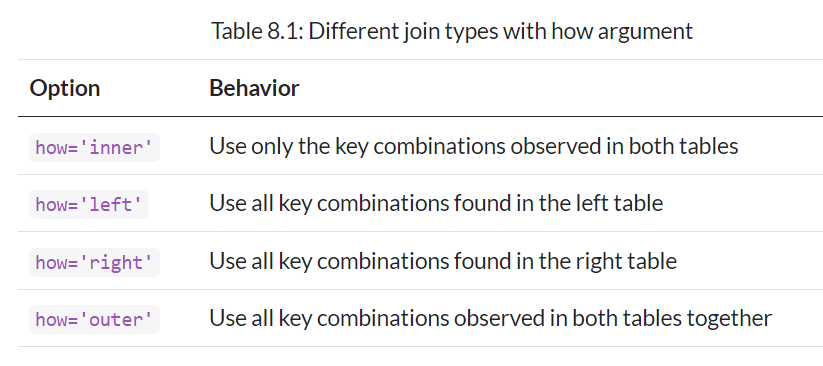

*Many-to-many* merges form the Cartesian product of the matching keys. Here’s an example:

In [19]:
df5 = pd.DataFrame({'key': ['b', 'b', 'a', 'c', 'a', 'b'],
                    'data1': range(6)})

df6 = pd.DataFrame({'key': ['a', 'b', 'a', 'b', 'd'],
                    'data2': range(5)}) 


In [ ]:
print(df5.describe())
print()
print(df5)

In [ ]:
print(df6.describe())
print()
print(df6)

In [ ]:
pd.merge(df5, df6, on='key', how='left')

Since there were three 'b' rows in the left DataFrame and two in the right one, there are six 'b' rows in the result. The `join` method only affects the distinct key values appearing in the result:

In [ ]:
pd.merge(df5, df6, how='inner')

To `merge` with multiple keys, pass a list of column names:


In [24]:
df_left = pd.DataFrame({'key1': ['foo', 'foo', 'bar'],
                     'key2': ['one', 'two', 'one'],
                     'lval': [1, 2, 3]})
 
df_right = pd.DataFrame({'key1': ['foo', 'foo', 'bar', 'bar'],
                      'key2': ['one', 'one', 'one', 'two'],
                      'rval': [4, 5, 6, 7]})


In [ ]:
print(df_left.describe())
print()
print(df_left)

In [ ]:
print(df_right.describe())
print()
print(df_right)

In [ ]:
pd.merge(df_left, df_right, on=['key1', 'key2'], how='outer')

To determine which key combinations will appear in the result depending on the choice of merge method, think of the multiple keys as forming an array of tuples to be used as a single join key.

***Caution***    


*When you're joining columns-on-columns, the indexes on the passed DataFrame objects are discarded.*

A last issue to consider in `merge` operations is the treatment of overlapping column names. While you can address the overlap manually (see the earlier section on renaming axis labels), `merge` has a `suffixes` option for specifying strings to append to overlapping names in the *left* and *right* DataFrame objects:

In [ ]:
pd.merge(df_left, df_right, on='key1')

In [ ]:
pd.merge(df_left, df_right, on='key1', suffixes=('_left', '_right'))



---





---





---



**Hierarchical indexing** is an important feature of pandas that enables you to have multiple (two or more) index levels on an axis. Another way of thinking about it is that it provides a way for you to work with higher dimensional data in a lower dimensional form. Let’s start with a simple example: create a Series with a list of lists (or arrays) as the index:

In [ ]:
data = pd.Series(np.random.randn(9),
       index=[['a', 'a', 'a', 'b', 'b', 'c', 'c', 'd', 'd'],
       [1, 2, 3, 1, 3, 1, 2, 2, 3]])

print(data)    


a  1    0.819729
   2    1.591709
   3   -0.380602
b  1   -0.481111
   3    0.321316
c  1   -0.528414
   2    1.701760
d  2    0.112483
   3    0.580383
dtype: float64


In [ ]:
corp = pd.Series(['first', 'second', 'third', 'fourth', 'fifth', 'sixth', 'seventh', 'eighth', 'ninth'], 
index=[['Americas', 'Americas', 'Americas', 'EMEA', 'EMEA', 'AsiaPac', 'AsiaPac', 'Corp', 'Corp'], 
[101, 201, 301, 101, 301, 101, 201, 201, 301]])

print(corp)    

Americas  101      first
          201     second
          301      third
EMEA      101     fourth
          301      fifth
AsiaPac   101      sixth
          201    seventh
Corp      201     eighth
          301      ninth
dtype: object


What you’re seeing is a prettified view of a Series with a MultiIndex as its index. The “gaps” in the index display mean “use the label directly above”:

In [ ]:
print(data.index)

MultiIndex([('a', 1),
            ('a', 2),
            ('a', 3),
            ('b', 1),
            ('b', 3),
            ('c', 1),
            ('c', 2),
            ('d', 2),
            ('d', 3)],
           )


In [ ]:
print(corp.index)

MultiIndex([('Americas', 101),
            ('Americas', 201),
            ('Americas', 301),
            (    'EMEA', 101),
            (    'EMEA', 301),
            ( 'AsiaPac', 101),
            ( 'AsiaPac', 201),
            (    'Corp', 201),
            (    'Corp', 301)],
           )


With a hierarchically indexed object, so-called partial indexing is possible, enabling you to concisely select subsets of the data:

In [ ]:
data['b']

1   -0.481111
3    0.321316
dtype: float64

In [ ]:
corp['EMEA']

101    fourth
301     fifth
dtype: object

In [ ]:
data['c']

1   -0.528414
2    1.701760
dtype: float64

In [ ]:
data['b':'c']

b  1   -0.481111
   3    0.321316
c  1   -0.528414
   2    1.701760
dtype: float64

In [ ]:
data['b':'d']

b  1   -0.481111
   3    0.321316
c  1   -0.528414
   2    1.701760
d  2    0.112483
   3    0.580383
dtype: float64

In [ ]:
data.loc[['b', 'd']]

b  1   -0.481111
   3    0.321316
d  2    0.112483
   3    0.580383
dtype: float64

In [ ]:
corp.loc[['EMEA', 'Americas', 'AsiaPac']]

EMEA      101     fourth
          301      fifth
Americas  101      first
          201     second
          301      third
AsiaPac   101      sixth
          201    seventh
dtype: object

Selection is even possible from an “inner” level. Here I select all of the values having the value "2" from the second index level:

In [ ]:
data.loc[:, 2]

a    1.591709
c    1.701760
d    0.112483
dtype: float64

In [ ]:
corp.loc[:,201]

Americas     second
AsiaPac     seventh
Corp         eighth
dtype: object

Hierarchical indexing plays an important role in reshaping data and group-based operations like forming a pivot table. For example, you can rearrange this data into a DataFrame using its `unstack` method:

In [ ]:
data.unstack()

,1,2,3
a,0.819729,1.591709,-0.380602
b,-0.481111,NaN,0.321316
c,-0.528414,1.701760,NaN
d,NaN,0.112483,0.580383


In [ ]:
corp.unstack()

,101,201,301
Americas,first,second,third
AsiaPac,sixth,seventh,NaN
Corp,NaN,eighth,ninth
EMEA,fourth,NaN,fifth


The inverse operation of unstack is stack:

In [ ]:
data.unstack().stack()

a  1    0.819729
   2    1.591709
   3   -0.380602
b  1   -0.481111
   3    0.321316
c  1   -0.528414
   2    1.701760
d  2    0.112483
   3    0.580383
dtype: float64

In [ ]:
corp.unstack().stack()

Americas  101      first
          201     second
          301      third
AsiaPac   101      sixth
          201    seventh
Corp      201     eighth
          301      ninth
EMEA      101     fourth
          301      fifth
dtype: object

`stack` and `unstack` are explored in more detail in [Chapter 8 of Wes Mckinney's Python for Data Analysis](https://wesmckinney.com/book/data-wrangling.html).

With a DataFrame, either axis can have a hierarchical index:


In [ ]:
frame = pd.DataFrame(np.arange(12).reshape((4, 3)),
            index=[['a', 'a', 'b', 'b'], [1, 2, 1, 2]],
            columns=[['Ohio', 'Ohio', 'Colorado'],
            ['Green', 'Red', 'Green']])

In [ ]:
print(frame)

     Ohio     Colorado
    Green Red    Green
a 1     0   1        2
  2     3   4        5
b 1     6   7        8
  2     9  10       11


The hierarchical levels can have names (as strings or any Python objects). If so, these will show up in the console output:


In [ ]:
# Assign key1 and key2 as `frame` index hierarchy names, respectively   
frame.index.names = ['key1', 'key2'] 

# Assign state and color as `frame` column hierarchy names, respectively 
frame.columns.names = ['state', 'color']


In [ ]:
print(frame)

state      Ohio     Colorado
color     Green Red    Green
key1 key2                   
a    1        0   1        2
     2        3   4        5
b    1        6   7        8
     2        9  10       11


In [ ]:
# Assign key1 and key2 as `frame` index hierarchy names, respectively   
frame.index.names = ['Region', 'Product'] 

# Assign state and color as `frame` column hierarchy names, respectively 
frame.columns.names = ['state', 'color']

In [ ]:
print(frame)

state           Ohio     Colorado
color          Green Red    Green
Region Product                   
a      1           0   1        2
       2           3   4        5
b      1           6   7        8
       2           9  10       11


***Caution***    
*Be careful to note the index names 'state' and 'color' are not part of the row labels (the `frame.index values`).*

With partial column indexing you can similarly select groups of columns:

In [ ]:
frame['Ohio']

color           Green  Red
Region Product            
a      1            0    1
       2            3    4
b      1            6    7
       2            9   10

A `MultiIndex` can be created by itself and then reused; the columns in the preceding DataFrame with level names could be created like this:

In [ ]:
pd.MultiIndex.from_arrays([['Ohio', 'Ohio', 'Colorado'],
                          ['Green', 'Red', 'Green']],
                          names=['state', 'color'])

MultiIndex([(    'Ohio', 'Green'),
            (    'Ohio',   'Red'),
            ('Colorado', 'Green')],
           names=['state', 'color'])

##Reordering and Sorting Levels    



At times you may need to rearrange the order of the levels on an axis or sort the data by the values in one specific level. The swaplevel takes two level numbers or names and returns a new object with the levels interchanged (but the data is otherwise unaltered):

In [ ]:
frame.swaplevel('key1', 'key2')

state      Ohio     Colorado
color     Green Red    Green
key2 key1                   
1    a        0   1        2
2    a        3   4        5
1    b        6   7        8
2    b        9  10       11

`sort_index`, on the other hand, sorts the data using only the values in a single level. When swapping levels, it’s not uncommon to also use `sort_index` so that the result is lexicographically sorted by the indicated level:

In [ ]:
frame.sort_index(level=1)

state      Ohio     Colorado
color     Green Red    Green
key1 key2                   
a    1        0   1        2
b    1        6   7        8
a    2        3   4        5
b    2        9  10       11

In [ ]:
frame.swaplevel(0, 1).sort_index(level=0)

***Note:***    

*Data selection performance is much better on hierarchically indexed objects if the index is lexicographically sorted starting with the outermost level—that is, the result of calling `sort_index(level=0)` or `sort_index()`.*    



##Summary Statistics by Level    



Many descriptive and summary statistics on DataFrame and Series have a `level` option in which you can specify the level you want to aggregate by on a particular axis. Consider the above DataFrame; we can aggregate by `level` on either the rows or columns like so:

In [ ]:
frame

In [ ]:
frame.groupby(level='key2').sum()

state  Ohio     Colorado
color Green Red    Green
key2                    
1         6   8       10
2        12  14       16

In [ ]:
frame.groupby(level='color', axis=1).sum()

color      Green  Red
key1 key2            
a    1         2    1
     2         8    4
b    1        14    7
     2        20   10

Internally, this utilizes pandas’s `groupby` machinery, which is discussed in more detail in the book [Python for Data Analysis](https://wesmckinney.com/book/data-aggregation.html).

##Indexing with a DataFrame's Columns    



It’s not unusual to want to use one or more columns from a DataFrame as the row index; alternatively, you may wish to move the row index into the DataFrame’s columns. Here’s an example DataFrame:

In [ ]:
frame = pd.DataFrame({'a': range(7), 'b': range(7, 0, -1),
            'c': ['one', 'one', 'one', 'two', 'two',
                 'two', 'two'],
            'd': [0, 1, 2, 0, 1, 2, 3]})


In [ ]:
print(frame)

   a  b    c  d
0  0  7  one  0
1  1  6  one  1
2  2  5  one  2
3  3  4  two  0
4  4  3  two  1
5  5  2  two  2
6  6  1  two  3


DataFrame’s `set_index` function will create a new DataFrame using one or more of its columns as the index:

In [ ]:
frame2 = frame.set_index(['c', 'd'])

In [ ]:
print(frame2)

       a  b
c   d      
one 0  0  7
    1  1  6
    2  2  5
two 0  3  4
    1  4  3
    2  5  2
    3  6  1


By default the columns are removed from the DataFrame, though you can leave them in by passing `drop=False` to `set_index`:

In [ ]:
frame.set_index(['c', 'd'], drop=False)

a  b    c  d
c   d              
one 0  0  7  one  0
    1  1  6  one  1
    2  2  5  one  2
two 0  3  4  two  0
    1  4  3  two  1
    2  5  2  two  2
    3  6  1  two  3

`reset_index`, on the other hand, does the opposite of `set_index`; the hierarchical index levels are moved into the columns:

In [ ]:
frame2.reset_index()

,c,d,a,b
0,one,0,0,7
1,one,1,1,6
2,one,2,2,5
3,two,0,3,4
4,two,1,4,3
5,two,2,5,2
6,two,3,6,1




---



#**Related Exercise**


*See the notebook ['Dewey_Dictionary'](https://bit.ly/dewey_notebook) for a related exercise on hierarchical indexing using the Dewey Decimal System.* 



---

